In [1]:
import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../../brickwall_ansatz_2D")
#from optimize import optimize, dynamics_opt
from utils_2D import construct_ising_local_term, reduce_list, X, I2
from ansatz_2D import ansatz_2D, ansatz_sparse
import rqcopt as oc

Lx, Ly = (3, 3)
L = Lx*Ly
t = 0.25
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 1)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix().toarray()
eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)/2 if L ==4 else construct_ising_local_term(J, 0, 0, ndim=2)
hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/4

Vlist_start = [
    scipy.linalg.expm(-1j*t*hloc1*0.5),
    scipy.linalg.expm(-1j*t*hloc2),
    scipy.linalg.expm(-1j*t*hloc1*0.5)
]*2
perms = [[0, 1, 3, 4, 6, 7], 
         [1, 2, 4, 5, 7, 8], 
         [2, 0, 5, 3, 8, 6], 
         [0, 3, 1, 4, 2, 5], 
         [3, 6, 4, 7, 5, 8], 
         [6, 0, 7, 1, 8, 2]]

X = np.array([[0, 1], [1, 0]])
I2 = np.array([[1, 0], [0, 1]])

U = scipy.linalg.expm(-1j*hamil*t)
#U_back = scipy.linalg.expm(1j*hamil*t)
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_2D(Vlist_start, L, perms) - U, ord=2) ))

Trotter error of the starting point:  0.2677916145840912


In [15]:
import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../src/brickwall_ansatz_2D")
#from optimize import optimize, dynamics_opt
from utils_2D import construct_ising_local_term, reduce_list, X, I2
from ansatz_2D import ansatz_2D, ansatz_sparse
import rqcopt as oc

Lx, Ly = (3, 3)
L = Lx*Ly
t = 0.25
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 1)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix().toarray()
eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)/2 if L == 4 else construct_ising_local_term(J, 0, 0, ndim=2)
hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/4
#hloc = construct_ising_local_term(J, 0, g, ndim=2)

perms_v = [[0, 1, 3, 4, 6, 7], [1, 2, 4, 5, 7, 8], [2, 0, 5, 3, 8, 6]]
perms_h = [[0, 3, 1, 4, 2, 5], [3, 6, 4, 7, 5, 8], [6, 0, 7, 1, 8, 2]]
#perms_v = [[0, 1, 2, 3], [1, 0, 3, 2]]
#perms_h = [[0, 2, 1, 3], [2, 0, 3, 1]]

V1 = scipy.linalg.expm(-1j*t*hloc1/2)
V2 = scipy.linalg.expm(-1j*t*hloc2)

V3 = scipy.linalg.expm(-1j*t*hloc1/4)
V4 = scipy.linalg.expm(-1j*t*hloc2/2)
Vlist_start = [V3, V4, V3, V1, V2, V1, V3, V4, V3]


eta1, eta2 = (3, 3) # eta1 here refers to the Trotter terms within each v or h perms (different hlocs).
                    # and eta2 refers to the Trotter terms in terms of v/h splitting (e.g. 3 for V-H-V splitting),
                    # takes odd values.
perms_v = [[0, 1, 3, 4, 6, 7], [1, 2, 4, 5, 7, 8], [2, 0, 5, 3, 8, 6]]
perms_h = [[0, 3, 1, 4, 2, 5], [3, 6, 4, 7, 5, 8], [6, 0, 7, 1, 8, 2]]
reps = len(perms_v) # How many times a V_i is repeated in terms of layers.
perms = perms_v*eta1 + perms_h*eta1
perms_extended = []
for i in range(eta1*eta2*reps):
    perms_extended.append(perms[i%len(perms)])

X = np.array([[0, 1], [1, 0]])
I2 = np.array([[1, 0], [0, 1]])

U = scipy.linalg.expm(-1j*hamil*t)
#U_back = scipy.linalg.expm(1j*hamil*t)
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_2D(Vlist_start, L, perms_extended, reps=len(perms_v)) - U, ord=2) ))

Trotter error of the starting point:  0.06981799451385608


0.003547554142222721


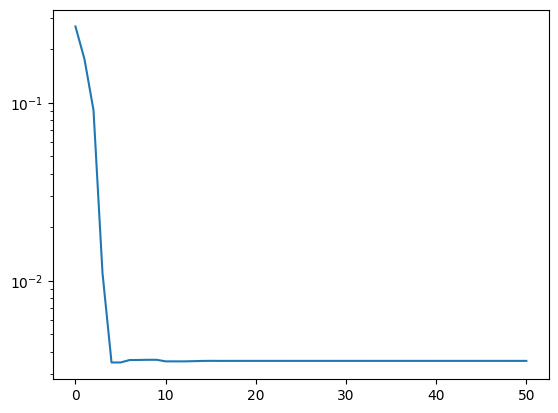

In [16]:
from optimize_2D import optimize

Vlist, f_iter, err_iter = optimize(L, U, Vlist_start, perms_extended, reps=len(perms_v), niter=50)
plt.plot(err_iter)
plt.yscale('log')
print(err_iter[-1])

In [30]:
#with h5py.File(f"./results/tfim2d_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist_start)}_U_3hloc.hdf5", "w") as f:
    f.create_dataset("Vlist", data=Vlist)
    f.create_dataset("f_iter", data=f_iter)
    f.create_dataset("err_iter", data=err_iter)
    f.attrs["L"] = L
    f.attrs["t"] = float(t)

In [12]:
"""Vlist = []
with h5py.File(f"./results/tfim2d_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist_start)}_U_3hloc.hdf5", "r") as f:
    Vlist =  f["Vlist"][:]"""


Vlist = []
with h5py.File("./results/tfim2d_101_Lx3Ly3_t0.25_layers9_U_v3.hdf5", "r") as f:
    Vlist =  f["Vlist"][:]

In [16]:
from scipy.sparse.linalg import expm_multiply

Lx, Ly = (3, 3)
L = Lx*Ly
t = 0.25
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 1)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]
#U = scipy.linalg.expm(-1j*hamil*t)

eta1, eta2 = (3, 3) # eta1 here refers to the Trotter terms within each v or h perms (different hlocs).
                    # and eta2 refers to the Trotter terms in terms of v/h splitting (e.g. 3 for V-H-V splitting),
                    # takes odd values.
perms_v = [[0, 1, 3, 4, 6, 7], [1, 2, 4, 5, 7, 8], [2, 0, 5, 3, 8, 6]]
perms_h = [[0, 3, 1, 4, 2, 5], [3, 6, 4, 7, 5, 8], [6, 0, 7, 1, 8, 2]]


reps = len(perms_v) # How many times a V_i is repeated in terms of layers.
perms = perms_v*eta1 + perms_h*eta1
perms_extended = []
for i in range(eta1*eta2*reps):
    perms_extended.append(perms[i%len(perms)])
#perms = perms_v + perms_h # 2 here refers to the Trotter terms within each v or h perms.
#perms_extended = perms*3

#print("Trotter error: ", (np.linalg.norm(ansatz_2D(Vlist, L, perms_extended, reps=reps) - U, ord=2) ))
print("Trotter error: ", np.linalg.norm(ansatz_sparse(Vlist, L, perms_extended, ground_state, reps=reps) - expm_multiply(
    -1j * t * hamil, ground_state), ord=2))

Trotter error:  0.002888919335212491


In [17]:
from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import state_fidelity

perms_v = [[0, 1, 4, 5, 8, 9, 12, 13, 2, 3, 6, 7, 10, 11, 14, 15], 
          [1, 2, 5, 6, 9, 10, 13, 14, 3, 0, 7, 4, 11, 8, 15, 12]]
perms_h = [[0, 4, 1, 5, 2, 6, 3, 7, 8, 12, 9, 13, 10, 14, 11, 15], 
          [4, 8, 5, 9, 6, 10, 7, 11, 12, 0, 13, 1, 14, 2, 15, 3]]
reps = len(perms_v) # How many times a V_i is repeated in terms of layers.
eta1, eta2 = (3, 3)
perms = perms_v*eta1 + perms_h*eta1
perms_extended = []
for i in range(eta1*eta2*reps):
    perms_extended.append(perms[i%len(perms)])
#perms = perms_v + perms_h # 2 here refers to the Trotter terms within each v or h perms.
#perms_extended = perms*3

Lx, Ly = (4, 4)
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 1)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

#print("Difference Norm: ", np.linalg.norm(ansatz_sparse(Vlist, L, perms, ground_state) - expm_multiply(
#    -1j * t * hamil, ground_state), ord=2))
print("Trotter error: ", np.linalg.norm(ansatz_sparse(Vlist, L, perms_extended, ground_state, reps=reps) - expm_multiply(
    -1j * t * hamil, ground_state), ord=2))

Trotter error:  0.004602165906379773


In [4]:
"""
    Attempt for the controlled version:
"""

import numpy as np
import qiskit
from qiskit.quantum_info import state_fidelity
from numpy import linalg as LA
import qib
import matplotlib.pyplot as plt
import scipy
import h5py

import sys
sys.path.append("../../src/brickwall_ansatz_2D")
#from optimize import optimize, dynamics_opt
from utils_2D import construct_ising_local_term, reduce_list, X, I2
from ansatz_2D import ansatz_2D, ansatz_sparse
import rqcopt as oc

Lx, Ly = (2, 2)
L = Lx*Ly
t = 0.25
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 1)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix().toarray()
eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

X = np.array([[0, 1], [1, 0]])
Z = np.array([[1, 0], [0, -1]])
Y = np.array([[0, -1j], [1j, 0]])
I2 = np.array([[1, 0], [0, 1]])

hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)
hloc2 = g*(np.kron(X, I2)+np.kron(I2, X))/4
V1 = scipy.linalg.expm(-1j*t*hloc1/2)
V2 = scipy.linalg.expm(-1j*t*hloc2)
V3 = scipy.linalg.expm(-1j*t*hloc1/4)
V4 = scipy.linalg.expm(-1j*t*hloc2/2)
YZ = np.kron(Y, Z)
Vlist_reduced = [V3, V4, V3, V1, V2, V1, V3, V4, V3]
#perms_v = [[0, 1, 3, 4, 6, 7], [1, 2, 4, 5, 7, 8], [2, 0, 5, 3, 8, 6]]
#perms_h = [[0, 3, 1, 4, 2, 5], [3, 6, 4, 7, 5, 8], [6, 0, 7, 1, 8, 2]]
perms_v = [[0, 1, 2, 3]]
perms_h = [[0, 2, 1, 3]]

eta1, eta2 = (3, 3) # eta1 here refers to the Trotter terms within each v or h perms (different hlocs).
                    # and eta2 refers to the Trotter terms in terms of v/h splitting (e.g. 3 for V-H-V splitting),
                    # takes odd values.
reps = len(perms_v) # How many times a V_i is repeated in terms of layers.
perms = perms_v*eta1 + perms_h*eta1
perms_ext_reduced = []
for i in range(eta1*eta2*reps):
    perms_ext_reduced.append(perms[i%len(perms)])

Vlist_start = [YZ, V3, V4, V3, YZ, YZ, V1, V2, V1, YZ, YZ, V3, V4, V3, YZ]
control_layers = [0, 4, 5, 9, 10, 14] # 6 control layers
perms_extended = perms_v*5 + perms_h*5 + perms_v*5

U = scipy.linalg.expm(-1j*hamil*t)
U_back = scipy.linalg.expm(1j*hamil*t)
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_2D(Vlist_start, L, perms_extended, reps=len(perms_v)) - U_back, ord=2) +\
                                                np.linalg.norm(ansatz_2D(Vlist_reduced, L, perms_ext_reduced, reps=len(perms_v)) - U, ord=2)
                                               )/2)


Trotter error of the starting point:  0.4846627248389517


0.00044071464503896596


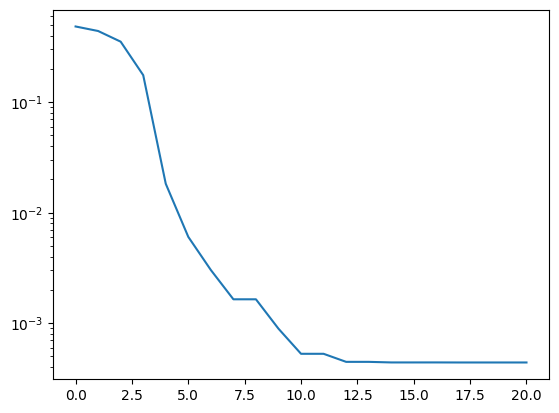

In [7]:
from optimize_2D import optimize

Vlist, f_iter, err_iter = optimize(L, U, Vlist_start, perms_extended, perms_reduced=perms_ext_reduced, 
                                   reps=len(perms_v), control_layers=control_layers, niter=20)
plt.plot(err_iter)
plt.yscale('log')
print(err_iter[-1])

In [9]:
Lx, Ly = (3, 3)
L = Lx*Ly
t = 0.25
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 1)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix().toarray()
eigenvalues, eigenvectors = LA.eig(hamil)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]


perms_v = [[0, 1, 3, 4, 6, 7], [1, 2, 4, 5, 7, 8], [2, 0, 5, 3, 8, 6]]
perms_h = [[0, 3, 1, 4, 2, 5], [3, 6, 4, 7, 5, 8], [6, 0, 7, 1, 8, 2]]
reps = len(perms_v) # How many times a V_i is repeated in terms of layers.
perms = perms_v*eta1 + perms_h*eta1
perms_ext_reduced = []
for i in range(eta1*eta2*reps):
    perms_ext_reduced.append(perms[i%len(perms)])
control_layers = [0, 4, 5, 9, 10, 14] # 6 control layers
perms_extended = perms_v*5 + perms_h*5 + perms_v*5


Vlist_reduced = []
for i, V in enumerate(Vlist):
    if i not in control_layers:
        Vlist_reduced.append(V)
U = scipy.linalg.expm(-1j*hamil*t)
U_back = scipy.linalg.expm(1j*hamil*t)
print("Trotter error of the starting point: ", (np.linalg.norm(ansatz_2D(Vlist, L, perms_extended, reps=len(perms_v)) - U_back, ord=2) +\
                                                np.linalg.norm(ansatz_2D(Vlist_reduced, L, perms_ext_reduced, reps=len(perms_v)) - U, ord=2)
                                               )/2)

Trotter error of the starting point:  1.8930500316683925


In [ ]:
"""
    Conclusion: We need the optimization to run on 4x4 directly. 2x2 is a special case that's
    not representative and 3x3 is not suitable for clear convergence as it doesnt have 
    anti commuting pauli string structure to be used as starting point.
"""

0.003382348027478038


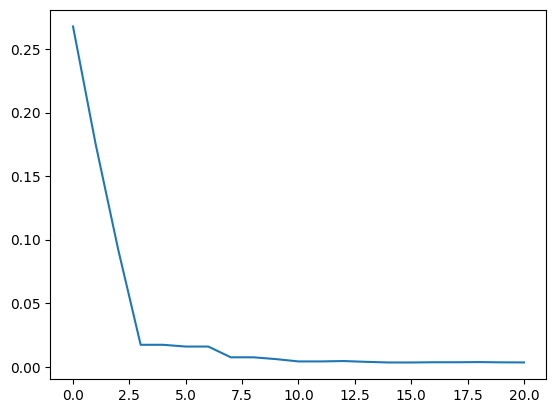

In [14]:
from optimize_2D import optimize


Vlist, f_iter, err_iter = optimize(L, U, Vlist_start, perms, niter=20)
print(err_iter[-1])
plt.plot(err_iter)

In [ ]:
with h5py.File(f"./results/tfim2d_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist)}_U.hdf5", "w") as f:
    f.create_dataset("Vlist", data=Vlist)
    f.create_dataset("f_iter", data=f_iter)
    f.create_dataset("err_iter", data=err_iter)
    f.attrs["L"] = L
    f.attrs["t"] = float(t)

In [2]:
Vlist = []
with h5py.File(f"./results/tfim2d_{J}{h}{g}_Lx{Lx}Ly{Ly}_t{t}_layers{len(Vlist_start)}_Uonly.hdf5", "r") as f:
    Vlist =  f["Vlist"][:]

In [3]:
perms = [[0, 1, 3, 4, 6, 7], [1, 2, 4, 5, 7, 8] , [2, 0, 5, 3, 8, 6], 
              [0, 3, 1, 4, 2, 5], [3, 6, 4, 7, 5, 8], [6, 0, 7, 1, 8, 2]
             ]
Lx, Ly = (3, 3)
L = Lx*Ly
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 1)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix().toarray()
U = scipy.linalg.expm(-1j*hamil*t)

print("Trotter error: ", (np.linalg.norm(ansatz_2D(Vlist, L, perms) - U, ord=2) ))

Trotter error:  0.003382348027478038


In [4]:
from scipy.sparse.linalg import expm_multiply
from qiskit.quantum_info import state_fidelity

perms = [ [0, 1, 4, 5, 8, 9, 12, 13, 2, 3, 6, 7, 10, 11, 14, 15], 
          [1, 2, 5, 6, 9, 10, 13, 14, 3, 0, 7, 4, 11, 8, 15, 12],
          [0, 4, 1, 5, 2, 6, 3, 7, 8, 12, 9, 13, 10, 14, 11, 15], 
          [4, 8, 5, 9, 6, 10, 7, 11, 12, 0, 13, 1, 14, 2, 15, 3]]

Lx, Ly = (4, 4)
L = Lx*Ly
# construct Hamiltonian
latt = qib.lattice.IntegerLattice((Lx, Ly), pbc=True)
field = qib.field.Field(qib.field.ParticleType.QUBIT, latt)
J, h, g = (1, 0, 1)
hamil = qib.IsingHamiltonian(field, J, h, g).as_matrix()
eigenvalues, eigenvectors = scipy.sparse.linalg.eigsh(hamil, k=10)
idx = eigenvalues.argsort()
eigenvalues_sort = eigenvalues[idx]
eigenvectors_sort = eigenvectors[:,idx]
ground_state = eigenvectors_sort[:, 0]

print("Difference Norm: ", np.linalg.norm(ansatz_sparse(Vlist, L, perms, ground_state) - expm_multiply(
    -1j * t * hamil, ground_state), ord=2))

Difference Norm:  0.004377929527117532


In [ ]:
t = .25
hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)
hloc2 = np.kron(X, I2)+np.kron(I2, X)
Vlist_start = []
perms = []
Vlist_start += [scipy.linalg.expm(-1j*t*hloc2/4)]
perms += [[i for i in range(L)]]
eta_indices = [0, 1, 2, 3]
eta_coeffs =  [.5, .5, .5, .5]
for i, c1 in zip(eta_indices, eta_coeffs):
    Vlist_start += [scipy.linalg.expm(-1j*t*hloc1*c1/2)]
    perms.append(perms_base[i])
Vlist_start += [scipy.linalg.expm(-1j*t*hloc2/2)]
perms += [[i for i in range(L)]]
eta_indices = [3, 2, 1, 0]
eta_coeffs =  [.5, .5, .5, .5]
for i, c1 in zip(eta_indices, eta_coeffs):
    Vlist_start += [scipy.linalg.expm(-1j*t*hloc1*c1/2)]
    perms.append(perms_base[i])
Vlist_start += [scipy.linalg.expm(-1j*t*hloc2/4)]
perms += [[i for i in range(L)]]

In [2]:
import numpy as np
from ansatz_2D import ansatz_2D_grad_vector
from utils_2D import antisymm_to_real, antisymm, partial_trace_keep
from optimize_2D import err as f



def grad_numerical(Glist, U, perms, reps=1, epsilon=1e-6, flatten=True, unprojected=False):
    grads = []
    for _ in range(len(Glist)):
        W = Glist[_]
        d = Glist[_].shape[0]
        grad_complex = np.zeros((d, d), dtype=complex)

        for i in range(d):
            for j in range(d):
                # Real perturbation
                dW_real = np.zeros_like(W, dtype=complex)
                dW_real[i, j] = epsilon

                Glist_plus_real  = Glist[:_] + [W + dW_real] + Glist[_+1:]
                Glist_minus_real = Glist[:_] + [W - dW_real] + Glist[_+1:]
                
                f_plus  = f(Glist_plus_real, U, L, perms, reps=reps)
                f_minus = f(Glist_minus_real, U, L, perms, reps=reps)
                df_real = (f_plus - f_minus) / (2 * epsilon)

                # Imaginary perturbation
                dW_imag = np.zeros_like(W, dtype=complex)
                dW_imag[i, j] = 1j * epsilon

                Glist_plus_imag  = Glist[:_] + [W + dW_imag] + Glist[_+1:]
                Glist_minus_imag = Glist[:_] + [W - dW_imag] + Glist[_+1:]
                
                f_plus  = f(Glist_plus_imag, U, L, perms, reps=reps)
                f_minus = f(Glist_minus_imag, U, L, perms, reps=reps)
                df_imag = (f_plus - f_minus) / (2 * epsilon)
    
                grad_complex[i, j] = df_real + 1j * df_imag
        grads.append(grad_complex)

    if unprojected:
        return grads
    
    stack = np.stack([ antisymm_to_real(antisymm(W.conj().T @ grads[j])) for j, W in enumerate(Glist)])
    if flatten:
        return stack.reshape(-1)
    return stack

# Random unitary generator
def random_unitary(n):
    A = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    Q, _ = np.linalg.qr(A)
    return Q
Glist = [random_unitary(4) for i in range(3)]*2

# Compute gradients
grad_a = -ansatz_2D_grad_vector(Glist, L, U, perms_extended, reps=len(perms_v))
grad_n = grad_numerical(Glist, U, perms_extended, reps=len(perms_v))

# Compare
error = np.linalg.norm(grad_a - grad_n)
print("Difference (Frobenius norm):", error)

Difference (Frobenius norm): 5.1379261126779365e-09


In [4]:
# Numerical Test function for: d/G_j d/dG_i f(G)
import sys
from hessian_2D import ansatz_2D_hessian_matrix
from utils_2D import real_to_antisymm, project_unitary_tangent


def numerical_hessian(Glist, U, L, perms, i, j, reps=1, epsilon=1e-6):
    """Numerically compute d/dW1 of projected gradient dL/dV1 (Riemannian)."""
    numerical_H = []

    for _ in range(16):
        Z_real = np.zeros(16)
        Z_real[_] = 1.0
        Z = real_to_antisymm(Z_real.reshape(4, 4))  # 4x4 anti-Hermitian direction

        Gj_plus  = Glist[j] @ scipy.linalg.expm(+epsilon*Z)
        Gj_minus = Glist[j] @ scipy.linalg.expm(-epsilon*Z)
    
        if i==j:
            grad_plus  = ansatz_2D_grad_vector(Glist[:j]+[Gj_plus]+Glist[j+1:], L, U, perms, unprojected=True, flatten=False, reps=len(perms_v))[i]
            grad_minus = ansatz_2D_grad_vector(Glist[:j]+[Gj_minus]+Glist[j+1:], L, U, perms, unprojected=True, flatten=False, reps=len(perms_v))[i]
            dgrad = (grad_plus - grad_minus) / (2 * epsilon)  # shape (16,)
            G = dgrad.reshape(4, 4)

            V = Glist[j]
            Z = V @ Z
            G = project_unitary_tangent(V, G)
            grad = ansatz_2D_grad_vector(Glist, L, U, perms, flatten=False, unprojected=True, reps=len(perms_v))[i]
            G -= 0.5 * (Z @ grad.conj().T @ V + V @ grad.conj().T @ Z)
            if not np.allclose(Z, project_unitary_tangent(V, Z)):
                G -= 0.5 * (Z @ V.conj().T + V @ Z.conj().T) @ grad
            G = antisymm_to_real(antisymm( V.conj().T @ G ))
        else:
            grad_plus  = ansatz_2D_grad_vector(Glist[:j]+[Gj_plus]+Glist[j+1:], L, U, perms, unprojected=False, flatten=False, reps=len(perms_v))[i]
            grad_minus = ansatz_2D_grad_vector(Glist[:j]+[Gj_minus]+Glist[j+1:], L, U, perms, unprojected=False, flatten=False, reps=len(perms_v))[i]
            dgrad = (grad_plus - grad_minus) / (2 * epsilon)  # shape (16,)
            G = dgrad.reshape(4, 4)
            
        numerical_H.append(G)
    
    return np.array(numerical_H)  # shape: (16, 4, 4)


# Random unitary generator
def random_unitary(n):
    A = np.random.randn(n, n) + 1j * np.random.randn(n, n)
    Q, _ = np.linalg.qr(A)
    return Q

i, j = 0, 3
#Glist = [random_unitary(4) for i in range(6)]
#H = ansatz_2D_hessian_matrix(Glist, L, U, perms_extended, reps=len(perms_v), unprojected=False, flatten=False)
grad = []
for _ in range(16):
    grad.append(H[i, :, j, _].reshape(4,4))
analytical = np.array(grad)
numerical = numerical_hessian(Glist, U, L, perms_extended, i, j, reps=len(perms_v))

print("Difference norm:", np.linalg.norm(numerical - analytical))


Difference norm: 2.0334895158312727e-08


In [ ]:
t = .25
hloc1 = construct_ising_local_term(J, 0, 0, ndim=2)/2
hloc2 = np.kron(X, I2)+np.kron(I2, X)
Vlist_start = []
perms = []
Vlist_start += [scipy.linalg.expm(-1j*t*hloc2/4)]
perms += [[i for i in range(L)]]
eta_indices = [0, 1, 2, 3]
eta_coeffs =  [.5, .5, .5, .5]
for i, c1 in zip(eta_indices, eta_coeffs):
    Vlist_start += [scipy.linalg.expm(-1j*t*hloc1*c1)]
    perms.append(perms_base[i])
Vlist_start += [scipy.linalg.expm(-1j*t*hloc2/2)]
perms += [[i for i in range(L)]]
eta_indices = [3, 2, 1, 0]
eta_coeffs =  [.5, .5, .5, .5]
for i, c1 in zip(eta_indices, eta_coeffs):
    Vlist_start += [scipy.linalg.expm(-1j*t*hloc1*c1)]
    perms.append(perms_base[i])
Vlist_start += [scipy.linalg.expm(-1j*t*hloc2/4)]
perms += [[i for i in range(L)]]

In [ ]:
perms = [[i for i in range(L)]]+[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
                                 [1, 2, 3, 0,  5, 6, 7, 4, 9, 10, 11, 8, 13, 14, 15, 12], 
                                 [0, 4, 1, 5, 2, 6, 3, 7, 8, 12, 9, 13, 10, 14, 11, 15], 
                                 [4, 8, 12, 0, 5, 9, 13, 1, 6, 10, 14, 2, 7, 11, 15, 3]] + [[i for i in range(L)]]+[
                                 [4, 8, 12, 0, 5, 9, 13, 1, 6, 10, 14, 2, 7, 11, 15, 3],
                                 [0, 4, 1, 5, 2, 6, 3, 7, 8, 12, 9, 13, 10, 14, 11, 15], 
                                 [1, 2, 3, 0,  5, 6, 7, 4, 9, 10, 11, 8, 13, 14, 15, 12],
                                 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]] + [[i for i in range(L)]]
#perms = []
#for i, c1 in zip(eta_indices, eta_coeffs):
#    perms.append(perms_base[i])

np.linalg.norm(ansatz_sparse(Vlist, L, perms, ground_state) - expm_multiply(-1j * t * hamil, ground_state), ord=2)